In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dill
import seaborn as sns

from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
import xgboost

sns.set()

In [2]:
# Load previously saved preprocessed data splits
with open('../results/data_split_nsr.pkl', 'rb') as file:
    data_split_nsr = dill.load(file)

ftr_names = ['L2 prox gbar', 'L5 prox gbar', 'L2 dist gbar', 'L5 dist gbar', 'Prox variance', 'Dist variance',
               'Prox mean time', 'Dist mean time']

In [7]:
# Load results from model training/tuning

results_dict = dict()
res_names = ['linear_regression', 'ridge_regression', 'kn_regression', 'xgb_regression']
regression_dict = {
    'linear_regression': LinearRegression,
    'ridge_regression': Ridge,
    'kn_regression': KNeighborsRegressor,
    'xgb_regression': xgboost.XGBRegressor
}

for name in res_names:
    with open(f'../results/{name}_results.pkl', 'rb') as file:
        results_dict[name] = dill.load(file)

In [8]:
# Calculate baseline score
dummy_reg = DummyRegressor()
baseline_scores = list()

for split_idx in range(len(data_split_nsr)):
    X_train = pd.DataFrame(data_split_nsr[split_idx]['X_train'], columns=ftr_names)
    X_test = pd.DataFrame(data_split_nsr[split_idx]['X_test'], columns=ftr_names)
    y_train, y_test = data_split_nsr[split_idx]['y_train'],  data_split_nsr[split_idx]['y_test']

    dummy_reg.fit(X_train, y_train)
    y_pred = dummy_reg.predict(y_test)
    baseline_scores.append(r2_score(y_test, y_pred))


In [9]:
test_scores = list()
test_error = list()

for name in res_names:
    model_scores = list()
    n_splits = len(results_dict[name])
    for split_idx in range(n_splits):
        n_states = len(results_dict[name][split_idx])
        for state_idx in range(n_states):
            model_scores.append(results_dict[name][split_idx][state_idx]['test_score'])
    
    test_scores.append(np.mean(model_scores))
    test_error.append(np.std(model_scores))

test_scores.append(np.mean(baseline_scores))
test_error.append(np.std(baseline_scores))

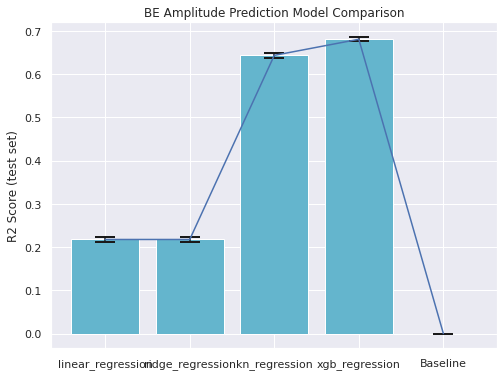

In [10]:
plot_labels = res_names + ['Baseline']

n_models = len(res_names) + 1

plt.figure(figsize=(8,6))
plt.bar(list(range(n_models)), test_scores, color='C9')
plt.errorbar(list(range(n_models)), test_scores, test_error, ecolor='k', capsize=10.0, zorder=12, capthick=2.0, linestyle='')
plt.xticks(list(range(n_models)), plot_labels)
plt.ylabel('R2 Score (test set)')
plt.title('BE Amplitude Prediction Model Comparison')
plt.savefig('../figures/model_test_scores.png')